In [1]:
import pandas as pd
import cv2
import numpy as np


from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

from keras.models import load_model


Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarn

In [2]:
dataset_path = './fer2013.csv'
image_size=(48,48)

In [3]:
def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).as_matrix()
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [4]:
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [5]:
# parameters
batch_size = 32
num_epochs = 110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = './'
l2_regularization=0.01
 
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
 
# model parameters
regularization = l2(l2_regularization)
 
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)


output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
 
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 46, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
# 훈련 시작 

xception_history = model.fit_generator(data_generator.flow(xtrain, ytrain, batch_size),
                    validation_data=(xtest, ytest),
                    steps_per_epoch=len(xtrain) / batch_size,
                    epochs=num_epochs, verbose=1, callbacks=callbacks)

Epoch 1/110
898/897 [==============================] - 427s 475ms/step - loss: 1.7812 - acc: 0.3242 - val_loss: 1.7658 - val_acc: 0.3480

Epoch 00001: val_loss improved from inf to 1.76577, saving model to ./_mini_XCEPTION.01-0.35.hdf5
Epoch 2/110
898/897 [==============================] - 428s 477ms/step - loss: 1.5085 - acc: 0.4313 - val_loss: 1.4346 - val_acc: 0.4765

Epoch 00002: val_loss improved from 1.76577 to 1.43457, saving model to ./_mini_XCEPTION.02-0.48.hdf5
Epoch 3/110
898/897 [==============================] - 422s 470ms/step - loss: 1.3883 - acc: 0.4816 - val_loss: 1.3724 - val_acc: 0.4933

Epoch 00003: val_loss improved from 1.43457 to 1.37240, saving model to ./_mini_XCEPTION.03-0.49.hdf5
Epoch 4/110
898/897 [==============================] - 405s 451ms/step - loss: 1.3225 - acc: 0.5023 - val_loss: 1.3389 - val_acc: 0.4941

Epoch 00004: val_loss improved from 1.37240 to 1.33886, saving model to ./_mini_XCEPTION.04-0.49.hdf5
Epoch 5/110
898/897 [=======================


Epoch 00041: val_loss did not improve
Epoch 42/110
898/897 [==============================] - 408s 455ms/step - loss: 0.9648 - acc: 0.6424 - val_loss: 1.0488 - val_acc: 0.6155

Epoch 00042: val_loss improved from 1.04905 to 1.04878, saving model to ./_mini_XCEPTION.42-0.62.hdf5
Epoch 43/110
898/897 [==============================] - 402s 448ms/step - loss: 0.9671 - acc: 0.6390 - val_loss: 1.0909 - val_acc: 0.6078

Epoch 00043: val_loss did not improve
Epoch 44/110
898/897 [==============================] - 407s 453ms/step - loss: 0.9596 - acc: 0.6444 - val_loss: 1.0563 - val_acc: 0.6162

Epoch 00044: val_loss did not improve
Epoch 45/110
898/897 [==============================] - 410s 456ms/step - loss: 0.9620 - acc: 0.6423 - val_loss: 1.1050 - val_acc: 0.6004

Epoch 00045: val_loss did not improve
Epoch 46/110
898/897 [==============================] - 408s 454ms/step - loss: 0.9555 - acc: 0.6449 - val_loss: 1.1541 - val_acc: 0.5773

Epoch 00046: val_loss did not improve
Epoch 47/110

898/897 [==============================] - 414s 461ms/step - loss: 0.8226 - acc: 0.6954 - val_loss: 1.0058 - val_acc: 0.6349

Epoch 00085: val_loss improved from 1.01209 to 1.00584, saving model to ./_mini_XCEPTION.85-0.63.hdf5
Epoch 86/110
898/897 [==============================] - 405s 451ms/step - loss: 0.8180 - acc: 0.6983 - val_loss: 1.0067 - val_acc: 0.6368

Epoch 00086: val_loss did not improve
Epoch 87/110
898/897 [==============================] - 414s 461ms/step - loss: 0.8197 - acc: 0.6967 - val_loss: 1.0128 - val_acc: 0.6375

Epoch 00087: val_loss did not improve
Epoch 88/110
898/897 [==============================] - 408s 455ms/step - loss: 0.8193 - acc: 0.6968 - val_loss: 1.0129 - val_acc: 0.6381

Epoch 00088: val_loss did not improve
Epoch 89/110
898/897 [==============================] - 410s 457ms/step - loss: 0.8187 - acc: 0.6990 - val_loss: 1.0118 - val_acc: 0.6342

Epoch 00089: val_loss did not improve
Epoch 90/110
898/897 [==============================] - 410s 457

In [7]:
model.save('my_model.h5')

In [8]:
from keras import backend as K

K.clear_session()
K.set_learning_phase(0)

In [9]:
model2 = load_model('my_model.h5')

In [10]:
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    
    
    graph = session.graph
    
    
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,output_names, freeze_var_names)
        return frozen_graph


In [11]:
print('inputs: ', [input.op.name for input in model2.inputs])
print('outputs: ', [output.op.name for output in model2.outputs])

frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model2.outputs])

inputs:  ['input_1']
outputs:  ['predictions/Softmax']
INFO:tensorflow:Froze 297 variables.
Converted 297 variables to const ops.


In [12]:
tf.train.write_graph(frozen_graph, "model", "tf_model_191203_07.pb", as_text=False)

'model/tf_model_191203_07.pb'

In [13]:
# 그래프 시작 

In [14]:
from keras.models import load_model

model = load_model('my_model.h5')

In [15]:
#Accuracy, loss 출력

#print('\nAccuracy: {:.4f}'.format(model.evaluate(xtest, ytest)[1]))

loss, acc = model.evaluate(xtest, ytest)

print("복원된 모델의 acc: {:5.2f}%".format(100*acc))
print("복원된 모델의 loss: {:5.2f}%".format(100*loss))

7178/7178 [==============================] - 32s 4ms/step
복원된 모델의 acc: 63.56%
복원된 모델의 loss: 101.46%


In [16]:
import matplotlib.pyplot as plt

def plot_history(histories, key='loss'):
    
    plt.figure(figsize=(16,10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],'--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),label=name.title()+' Train')
        
        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        
        plt.xlim([0,max(history.epoch)])

        
plot_history([('Xception', xception_history)])

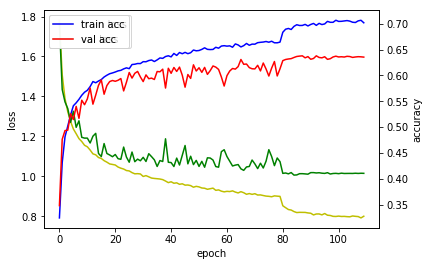

In [17]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(xception_history.history['loss'], 'y', label='train loss')
loss_ax.plot(xception_history.history['val_loss'], 'g', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(xception_history.history['acc'], 'b', label='train acc')
acc_ax.plot(xception_history.history['val_acc'], 'r', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
# 끝 

In [7]:
model.save('my_model.h5')

In [8]:
from keras import backend as K

K.clear_session()
K.set_learning_phase(0)

In [9]:
model2 = load_model('my_model.h5')

In [10]:
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    
    
    graph = session.graph
    
    
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,output_names, freeze_var_names)
        return frozen_graph


In [11]:
print('inputs: ', [input.op.name for input in model2.inputs])
print('outputs: ', [output.op.name for output in model2.outputs])

frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model2.outputs])

inputs:  ['input_1']
outputs:  ['predictions/Softmax']
INFO:tensorflow:Froze 297 variables.
Converted 297 variables to const ops.


In [12]:
tf.train.write_graph(frozen_graph, "model", "tf_model_191203_07.pb", as_text=False)

'model/tf_model_191203_06.pb'